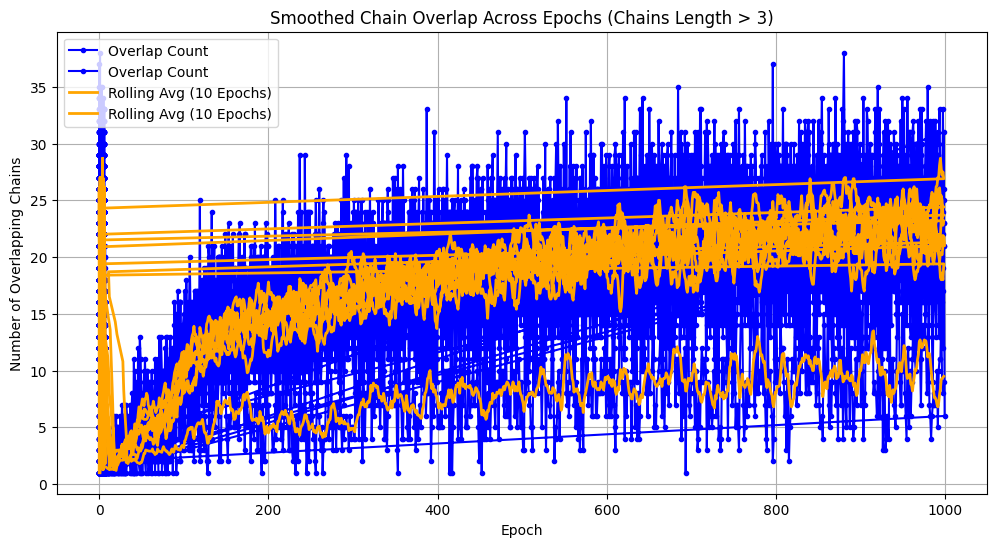

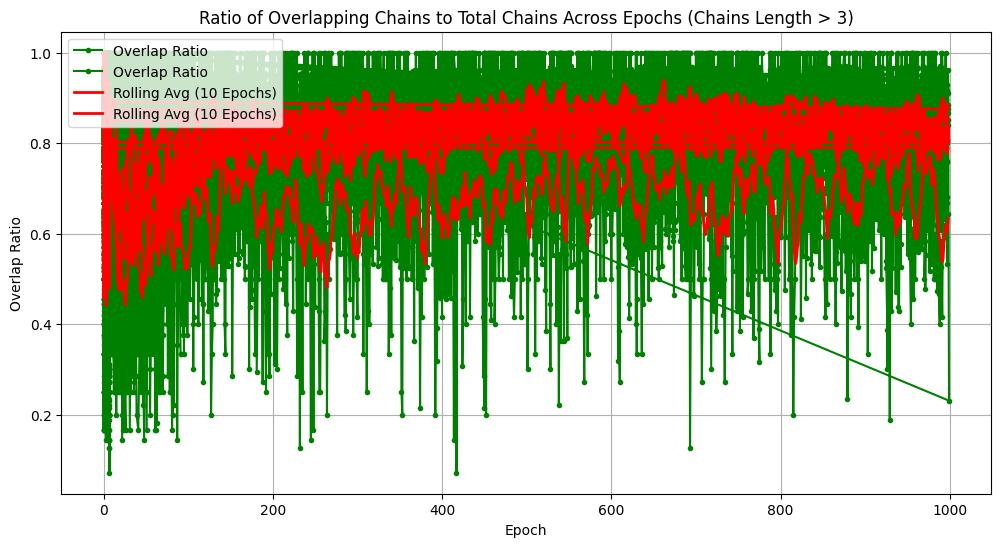

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Define thresholds for filtering chains
POSITIVE_THRESHOLD = 0.5

# Define the minimum chain length for overlap analysis
MIN_CHAIN_LENGTH = 3

# Load the hidden states CSV file
csv_file = 'hidden_states.csv'
data = pd.read_csv(csv_file, header=None)

# Assign column names
n_neurons = data.shape[1] - 2  # Exclude Batch and Epoch columns
column_names = [f'Neuron_{i+1}' for i in range(n_neurons)] + ['Batch', 'Epoch']
data.columns = column_names

# Chain Detection with Filtering
def detect_chains(data):
    chains = defaultdict(list)
    for batch_epoch, df in data.groupby(['Batch', 'Epoch']):
        active_chain = None
        for idx, row in df.iterrows():
            for neuron_idx, value in enumerate(row[:-2]):
                if value > POSITIVE_THRESHOLD:  # Positive chain with threshold
                    if active_chain is None or active_chain[-1][2] != 'positive':
                        if active_chain:
                            chains[batch_epoch].append(active_chain)
                        active_chain = [(batch_epoch, neuron_idx, 'positive', value)]
                    else:
                        active_chain.append((batch_epoch, neuron_idx, 'positive', value))
                else:
                    if active_chain:
                        chains[batch_epoch].append(active_chain)
                        active_chain = None

            if active_chain:
                chains[batch_epoch].append(active_chain)
                active_chain = None  # Reset chain for next row

    return chains

# Detect chains in the data
chains_by_epoch = detect_chains(data)

# Filter chains by minimum length
def filter_chains_by_length(chains_by_epoch, min_length):
    filtered_chains = {}
    for epoch, chains in chains_by_epoch.items():
        filtered_chains[epoch] = [chain for chain in chains if len(chain) > min_length]
    return filtered_chains

filtered_chains_by_epoch = filter_chains_by_length(chains_by_epoch, MIN_CHAIN_LENGTH)

# Analyze chain overlap across epochs
def analyze_chain_overlap(chains_by_epoch):
    chain_overlap = defaultdict(list)
    overlap_ratios = {}
    
    # Iterate over epochs to find overlaps
    epochs = sorted(chains_by_epoch.keys())
    for i in range(len(epochs) - 1):
        current_epoch = epochs[i]
        next_epoch = epochs[i + 1]
        current_chains = chains_by_epoch[current_epoch]
        next_chains = chains_by_epoch[next_epoch]
        
        # Convert chains to sets of neuron IDs for comparison
        current_chain_sets = [set((neuron[1] for neuron in chain)) for chain in current_chains]
        next_chain_sets = [set((neuron[1] for neuron in chain)) for chain in next_chains]
        
        overlap_count = 0
        for current_chain in current_chain_sets:
            for next_chain in next_chain_sets:
                if current_chain.issubset(next_chain):
                    chain_overlap[current_epoch].append(len(current_chain))
                    overlap_count += 1
                    break
        
        # Calculate ratio of overlapping to total chains
        if len(current_chain_sets) > 0:
            overlap_ratios[current_epoch] = overlap_count / len(current_chain_sets)
        else:
            overlap_ratios[current_epoch] = 0

    return chain_overlap, overlap_ratios

chain_overlap, overlap_ratios = analyze_chain_overlap(filtered_chains_by_epoch)

# Analyze the change in chain overlap over epochs
overlap_counts = {epoch: len(overlaps) for epoch, overlaps in chain_overlap.items()}

# Clean up the plot: moving average smoothing
def moving_average(data, window_size):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean().tolist()

# Sort the epochs for correct plotting
sorted_epochs = sorted(overlap_counts.keys())
sorted_overlap_counts = [overlap_counts[epoch] for epoch in sorted_epochs]
sorted_overlap_ratios = [overlap_ratios[epoch] for epoch in sorted_epochs]

# Calculate the rolling average
rolling_avg_overlap = moving_average(sorted_overlap_counts, window_size=10)
rolling_avg_ratio = moving_average(sorted_overlap_ratios, window_size=10)

# Plot the cleaned-up overlap trend over epochs
plt.figure(figsize=(12, 6))
plt.plot(sorted_epochs, sorted_overlap_counts, color='blue', marker='o', linestyle='-', markersize=3, label='Overlap Count')
plt.plot(sorted_epochs, rolling_avg_overlap, color='orange', linestyle='-', linewidth=2, label='Rolling Avg (10 Epochs)')
plt.title('Smoothed Chain Overlap Across Epochs (Chains Length > 3)')
plt.xlabel('Epoch')
plt.ylabel('Number of Overlapping Chains')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

# Plot the ratio of overlapping chains to total chains with rolling average
plt.figure(figsize=(12, 6))
plt.plot(sorted_epochs, sorted_overlap_ratios, color='green', marker='o', linestyle='-', markersize=3, label='Overlap Ratio')
plt.plot(sorted_epochs, rolling_avg_ratio, color='red', linestyle='-', linewidth=2, label='Rolling Avg (10 Epochs)')
plt.title('Ratio of Overlapping Chains to Total Chains Across Epochs (Chains Length > 3)')
plt.xlabel('Epoch')
plt.ylabel('Overlap Ratio')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()


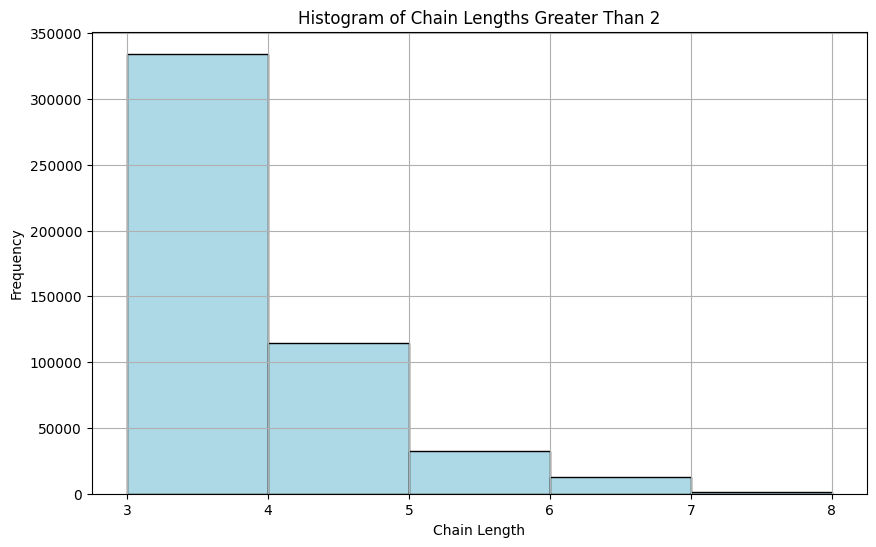

Total number of chains with length greater than 2: 495197
Number of chains being plotted with exact length 7: 330


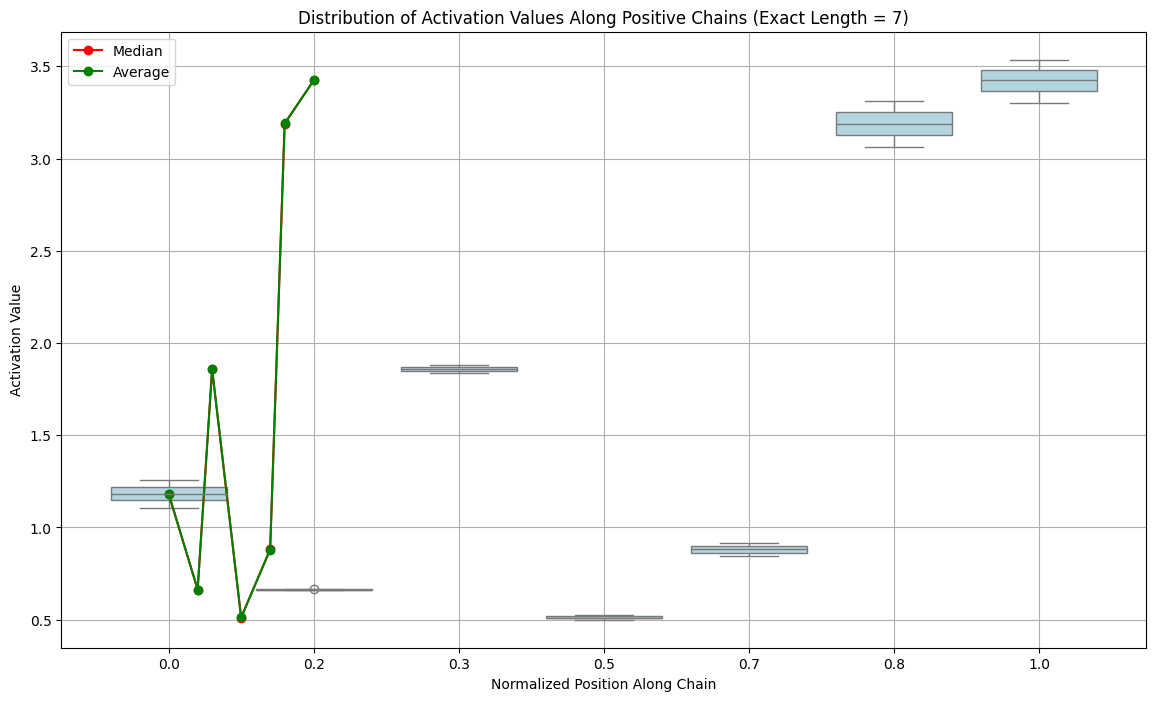

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define thresholds for filtering chains
POSITIVE_THRESHOLD = 0.5

# Define the exact chain length for analysis
EXACT_CHAIN_LENGTH = 7  # Modify this value to filter chains of this exact length

# Load the hidden states CSV file
csv_file = 'hidden_states.csv'
data = pd.read_csv(csv_file, header=None)

# Assign column names
n_neurons = data.shape[1] - 2  # Exclude Batch and Epoch columns
column_names = [f'Neuron_{i+1}' for i in range(n_neurons)] + ['Batch', 'Epoch']
data.columns = column_names

# Chain Detection with Filtering
def detect_chains(data):
    chains = []
    for batch_epoch, df in data.groupby(['Batch', 'Epoch']):
        active_chain = None
        for idx, row in df.iterrows():
            for neuron_idx, value in enumerate(row[:-2]):
                if value > POSITIVE_THRESHOLD:  # Positive chain with threshold
                    if active_chain is None or active_chain[-1][2] != 'positive':
                        if active_chain:
                            chains.append(active_chain)
                        active_chain = [(batch_epoch, neuron_idx, 'positive', value)]
                    else:
                        active_chain.append((batch_epoch, neuron_idx, 'positive', value))
                else:
                    if active_chain:
                        chains.append(active_chain)
                        active_chain = None

            if active_chain:
                chains.append(active_chain)
                active_chain = None  # Reset chain for next row

    return chains

# Detect chains in the data
chains = detect_chains(data)

# Filter chains with length greater than 2
chains_greater_than_2 = [chain for chain in chains if len(chain) > 2]

# Print the histogram and number of chains greater than 2
chain_lengths = [len(chain) for chain in chains_greater_than_2]
plt.figure(figsize=(10, 6))
plt.hist(chain_lengths, bins=range(3, max(chain_lengths)+1), color='lightblue', edgecolor='black')
plt.title('Histogram of Chain Lengths Greater Than 2')
plt.xlabel('Chain Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Total number of chains with length greater than 2: {len(chains_greater_than_2)}")

# Filter chains by exact length
filtered_chains = [chain for chain in chains if len(chain) == EXACT_CHAIN_LENGTH]

# Print the number of chains being plotted
print(f"Number of chains being plotted with exact length {EXACT_CHAIN_LENGTH}: {len(filtered_chains)}")

# Analyze chain position distributions (for positive chains only)
def analyze_chain_positions(chains):
    normalized_positions = []
    activation_values = []

    for chain in chains:
        if chain[0][2] == 'positive':  # Only consider positive chains
            chain_length = len(chain)
            for idx, node in enumerate(chain):
                normalized_position = round(idx / (chain_length - 1), 1)  # Normalize position and round to 1 decimal
                activation_value = node[3]
                
                normalized_positions.append(normalized_position)
                activation_values.append(activation_value)
    
    return pd.DataFrame({
        'Normalized Position': normalized_positions,
        'Activation Value': activation_values
    })

position_data = analyze_chain_positions(filtered_chains)

# Calculate median and average for each unique normalized position present in the plot
plot_positions = sorted(position_data['Normalized Position'].unique())
median_values = position_data.groupby('Normalized Position')['Activation Value'].median().reindex(plot_positions)
average_values = position_data.groupby('Normalized Position')['Activation Value'].mean().reindex(plot_positions)

# Plot the boxplot with median and average lines
plt.figure(figsize=(14, 8))
sns.boxplot(x='Normalized Position', y='Activation Value', data=position_data, color='lightblue')
plt.plot(median_values.index, median_values.values, color='red', marker='o', label='Median')
plt.plot(average_values.index, average_values.values, color='green', marker='o', label='Average')
plt.title(f'Distribution of Activation Values Along Positive Chains (Exact Length = {EXACT_CHAIN_LENGTH})')
plt.xlabel('Normalized Position Along Chain')
plt.ylabel('Activation Value')
plt.legend()
plt.grid(True)
plt.show()


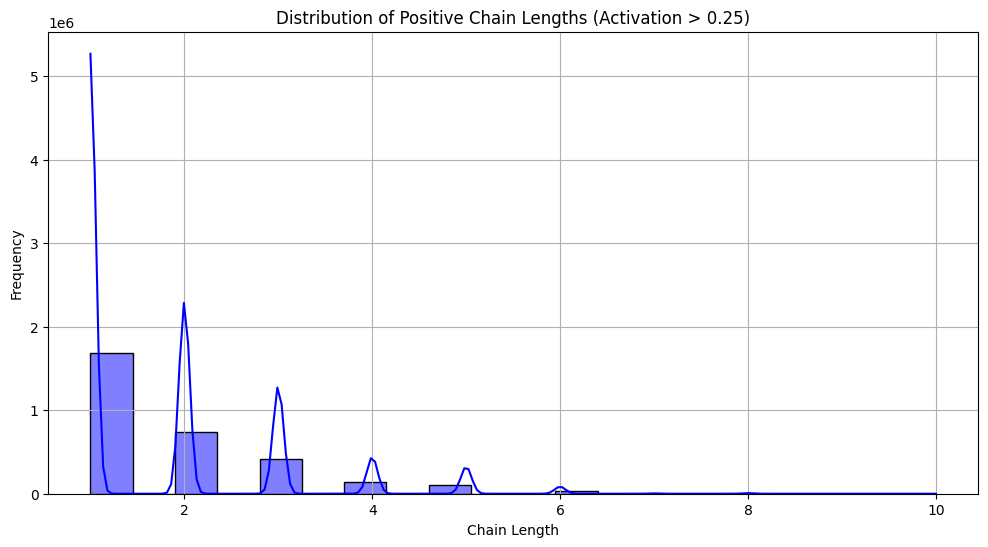

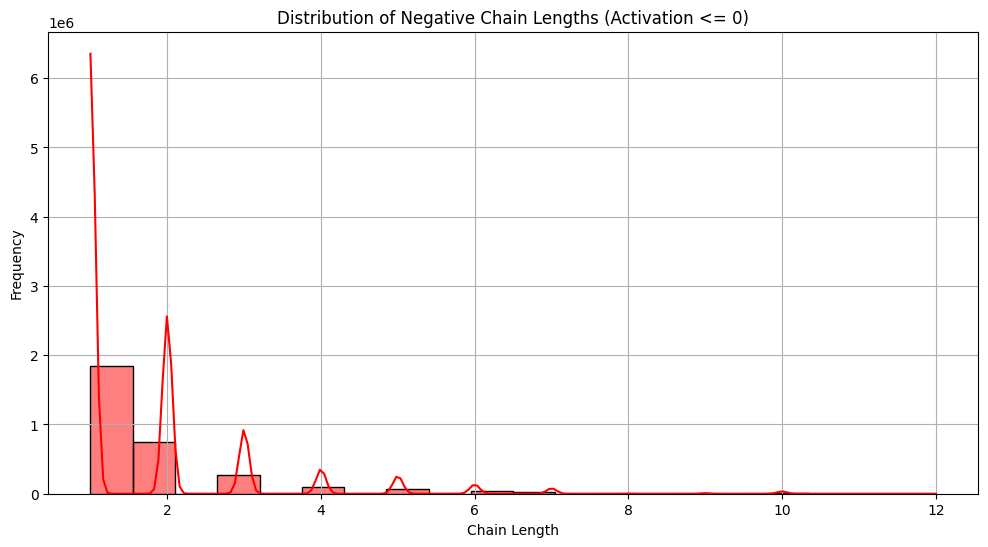

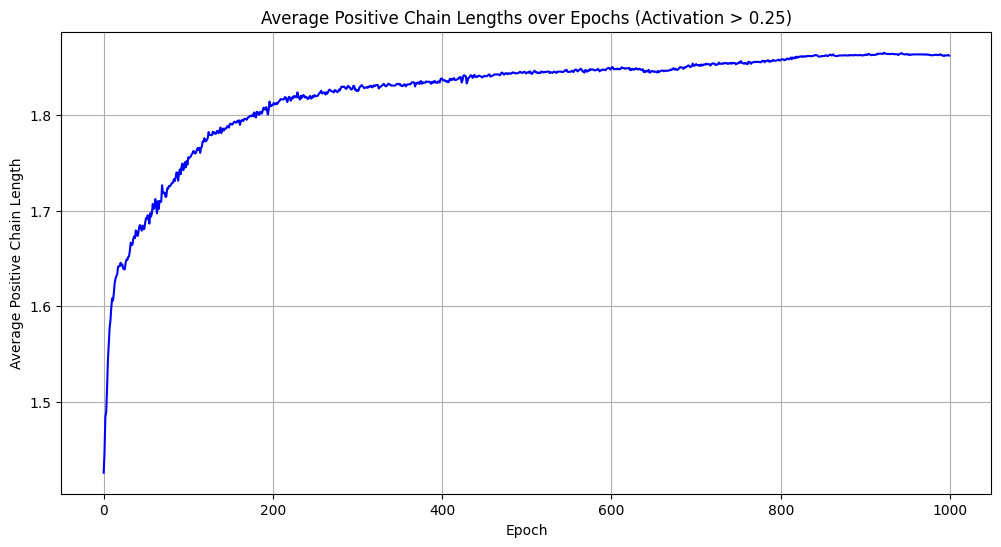

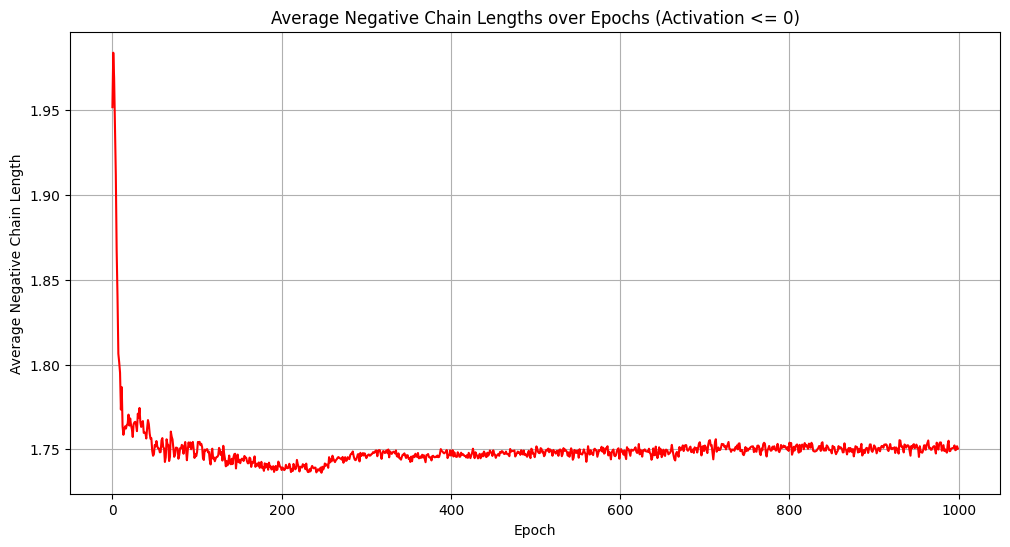

Positive Chain Analysis
Total number of positive chains: 3109433
Average positive chain length: 1.82
Maximum positive chain length: 10
Minimum positive chain length: 1

Negative Chain Analysis
Total number of negative chains: 3100147
Average negative chain length: 1.75
Maximum negative chain length: 12
Minimum negative chain length: 1



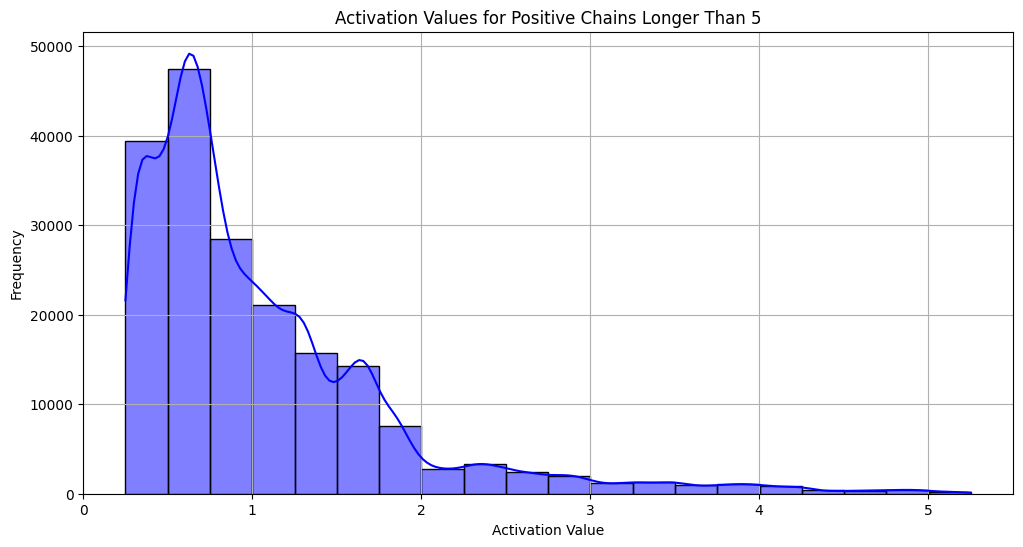

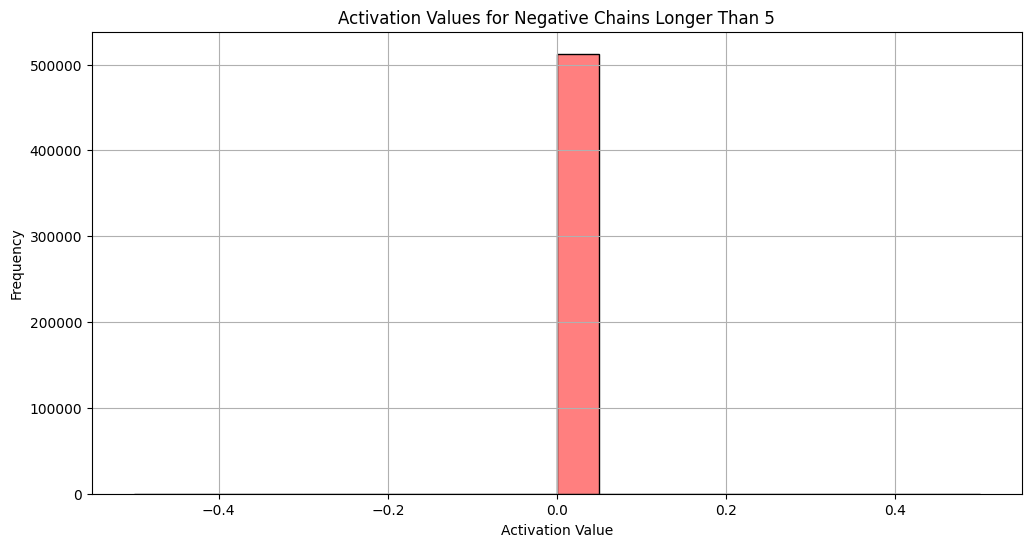

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define thresholds for filtering chains
POSITIVE_THRESHOLD = 0.25
NEGATIVE_THRESHOLD = 0  # For negative chains, consider anything <= NEGATIVE_THRESHOLD as negative

# Define the minimum chain length for additional analysis
MIN_CHAIN_LENGTH = 5  # Modify this value to filter chains longer than this length

# Load the hidden states CSV file
csv_file = 'hidden_states.csv'
data = pd.read_csv(csv_file, header=None)

# Assign column names
n_neurons = data.shape[1] - 2  # Exclude Batch and Epoch columns
column_names = [f'Neuron_{i+1}' for i in range(n_neurons)] + ['Batch', 'Epoch']
data.columns = column_names

# Chain Detection with Filtering
def detect_chains(data):
    chains = []
    for batch_epoch, df in data.groupby(['Batch', 'Epoch']):
        active_chain = None
        for idx, row in df.iterrows():
            for neuron_idx, value in enumerate(row[:-2]):
                if value > POSITIVE_THRESHOLD:  # Positive chain with threshold
                    if active_chain is None or active_chain[-1][2] != 'positive':
                        if active_chain:
                            chains.append(active_chain)
                        active_chain = [(batch_epoch, neuron_idx, 'positive', value)]
                    else:
                        active_chain.append((batch_epoch, neuron_idx, 'positive', value))
                elif value <= NEGATIVE_THRESHOLD:  # Negative chain (<= threshold)
                    if active_chain is None or active_chain[-1][2] != 'negative':
                        if active_chain:
                            chains.append(active_chain)
                        active_chain = [(batch_epoch, neuron_idx, 'negative', value)]
                    else:
                        active_chain.append((batch_epoch, neuron_idx, 'negative', value))
                else:
                    if active_chain:
                        chains.append(active_chain)
                        active_chain = None

            if active_chain:
                chains.append(active_chain)
                active_chain = None  # Reset chain for next row

    return chains

# Detect chains in the data
chains = detect_chains(data)

# Filter chains based on length
def filter_chains_by_length(chains, min_length):
    filtered_chains = [chain for chain in chains if len(chain) > min_length]
    return filtered_chains

filtered_chains = filter_chains_by_length(chains, MIN_CHAIN_LENGTH)

# Analyze chains
def analyze_chains(chains):
    positive_chain_lengths = []
    negative_chain_lengths = []

    for chain in chains:
        chain_type = chain[0][2]
        chain_length = len(chain)
        if chain_type == 'positive':
            positive_chain_lengths.append(chain_length)
        else:
            negative_chain_lengths.append(chain_length)
    
    return positive_chain_lengths, negative_chain_lengths

positive_chain_lengths, negative_chain_lengths = analyze_chains(chains)

# Plot the distribution of chain lengths
plt.figure(figsize=(12, 6))
sns.histplot(positive_chain_lengths, kde=True, color='blue', bins=20)
plt.title(f'Distribution of Positive Chain Lengths (Activation > {POSITIVE_THRESHOLD})')
plt.xlabel('Chain Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(negative_chain_lengths, kde=True, color='red', bins=20)
plt.title(f'Distribution of Negative Chain Lengths (Activation <= {NEGATIVE_THRESHOLD})')
plt.xlabel('Chain Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Analyze chaining over epochs
def chaining_over_epochs(chains):
    chain_lengths_by_epoch = {'positive': {}, 'negative': {}}
    for chain in chains:
        epoch = chain[0][0][1]  # Extract epoch from batch-epoch tuple
        chain_type = chain[0][2]
        chain_length = len(chain)
        
        if chain_type == 'positive':
            if epoch not in chain_lengths_by_epoch['positive']:
                chain_lengths_by_epoch['positive'][epoch] = []
            chain_lengths_by_epoch['positive'][epoch].append(chain_length)
        else:
            if epoch not in chain_lengths_by_epoch['negative']:
                chain_lengths_by_epoch['negative'][epoch] = []
            chain_lengths_by_epoch['negative'][epoch].append(chain_length)
    
    return chain_lengths_by_epoch

chain_lengths_by_epoch = chaining_over_epochs(chains)

# Average chain lengths over epochs
positive_avg_chain_lengths = {epoch: sum(lengths) / len(lengths) for epoch, lengths in chain_lengths_by_epoch['positive'].items()}
negative_avg_chain_lengths = {epoch: sum(lengths) / len(lengths) for epoch, lengths in chain_lengths_by_epoch['negative'].items()}

# Plot chaining over epochs
plt.figure(figsize=(12, 6))
sns.lineplot(x=list(positive_avg_chain_lengths.keys()), y=list(positive_avg_chain_lengths.values()), color='blue')
plt.title(f'Average Positive Chain Lengths over Epochs (Activation > {POSITIVE_THRESHOLD})')
plt.xlabel('Epoch')
plt.ylabel('Average Positive Chain Length')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(x=list(negative_avg_chain_lengths.keys()), y=list(negative_avg_chain_lengths.values()), color='red')
plt.title(f'Average Negative Chain Lengths over Epochs (Activation <= {NEGATIVE_THRESHOLD})')
plt.xlabel('Epoch')
plt.ylabel('Average Negative Chain Length')
plt.grid(True)
plt.show()

# Detailed Analysis
def detailed_chain_analysis(chain_lengths, chain_type):
    print(f"{chain_type.capitalize()} Chain Analysis")
    print(f"Total number of {chain_type} chains: {len(chain_lengths)}")
    print(f"Average {chain_type} chain length: {sum(chain_lengths)/len(chain_lengths):.2f}")
    print(f"Maximum {chain_type} chain length: {max(chain_lengths)}")
    print(f"Minimum {chain_type} chain length: {min(chain_lengths)}")
    print()

# Print detailed chain analysis
detailed_chain_analysis(positive_chain_lengths, 'positive')
detailed_chain_analysis(negative_chain_lengths, 'negative')

# Additional Analysis: Chain Activations for Chains Longer Than MIN_CHAIN_LENGTH
def analyze_chain_activations(chains):
    positive_activations = []
    negative_activations = []

    for chain in chains:
        chain_type = chain[0][2]
        activations = [node[3] for node in chain]
        if chain_type == 'positive':
            positive_activations.extend(activations)
        else:
            negative_activations.extend(activations)

    return positive_activations, negative_activations

positive_activations, negative_activations = analyze_chain_activations(filtered_chains)

# Plot activation distributions for long chains
plt.figure(figsize=(12, 6))
sns.histplot(positive_activations, kde=True, color='blue', bins=20)
plt.title(f'Activation Values for Positive Chains Longer Than {MIN_CHAIN_LENGTH}')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(negative_activations, kde=True, color='red', bins=20)
plt.title(f'Activation Values for Negative Chains Longer Than {MIN_CHAIN_LENGTH}')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


General Analysis Metrics for Epochs 0-1000:
Total number of activation chains: 120
Total number of neurons activated: 6282516
Average chain length: 52354.30
Maximum chain length: 70283
Minimum chain length: 34155
Average activation value: 0.8269
Maximum activation value: 14.8312
Minimum activation value: 0.0000




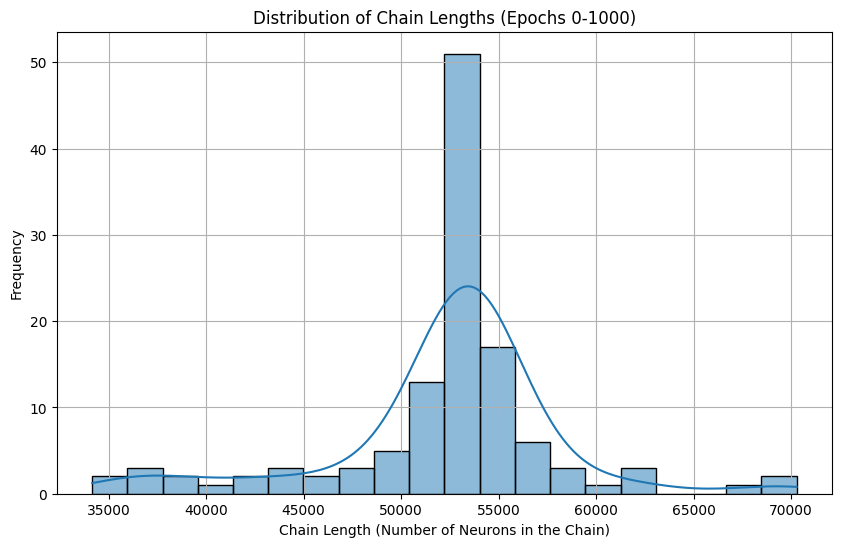

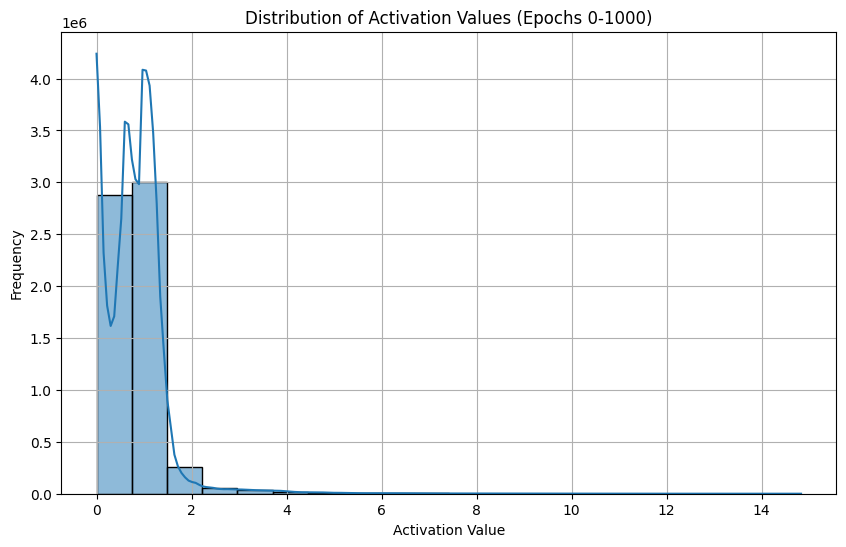

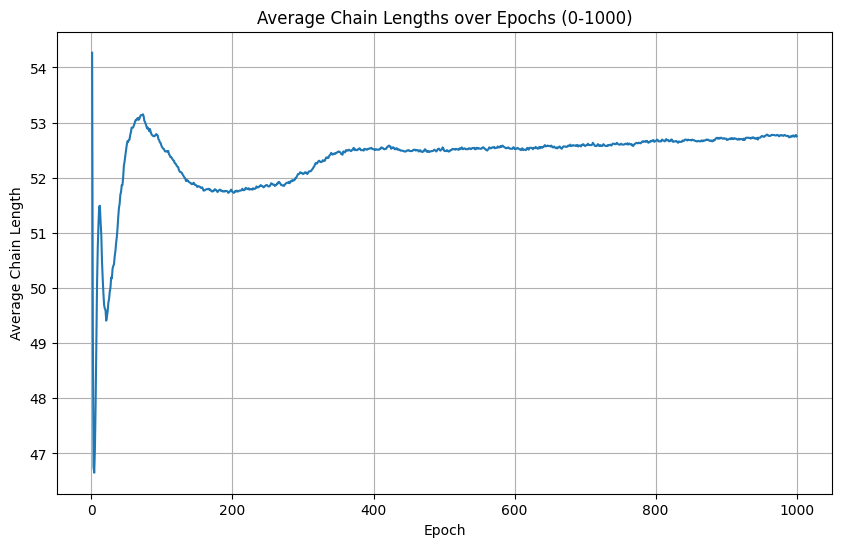

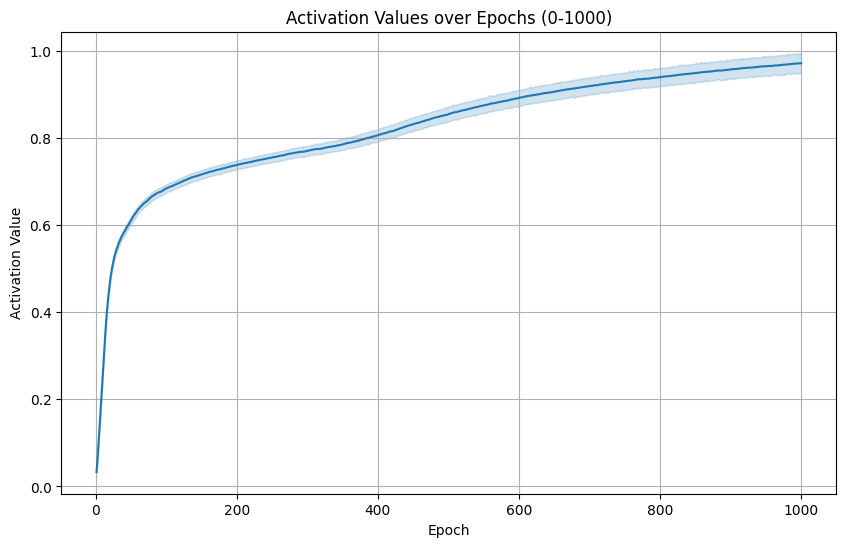

Analysis for Epoch Range: 0 to 1000
General Analysis Metrics for Epochs 0-1000:
Total number of activation chains: 120
Total number of neurons activated: 6282516
Average chain length: 52354.30
Maximum chain length: 70283
Minimum chain length: 34155
Average activation value: 0.8269
Maximum activation value: 14.8312
Minimum activation value: 0.0000




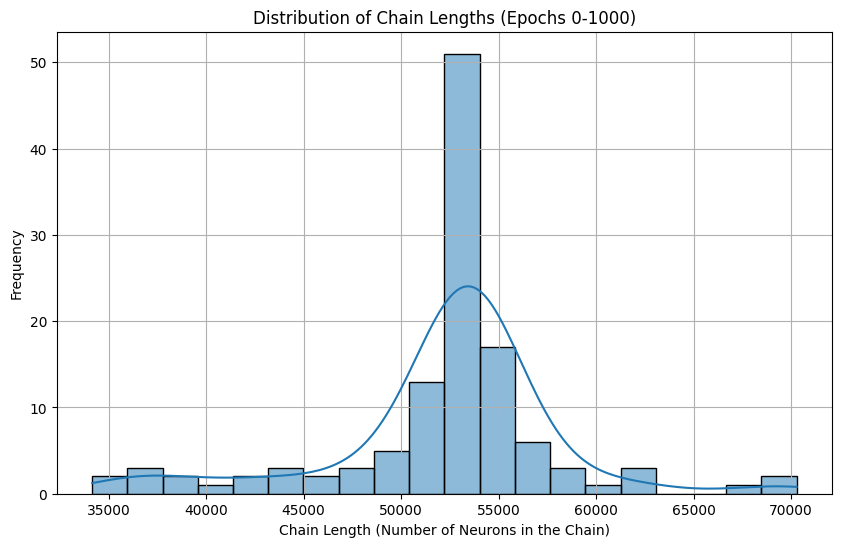

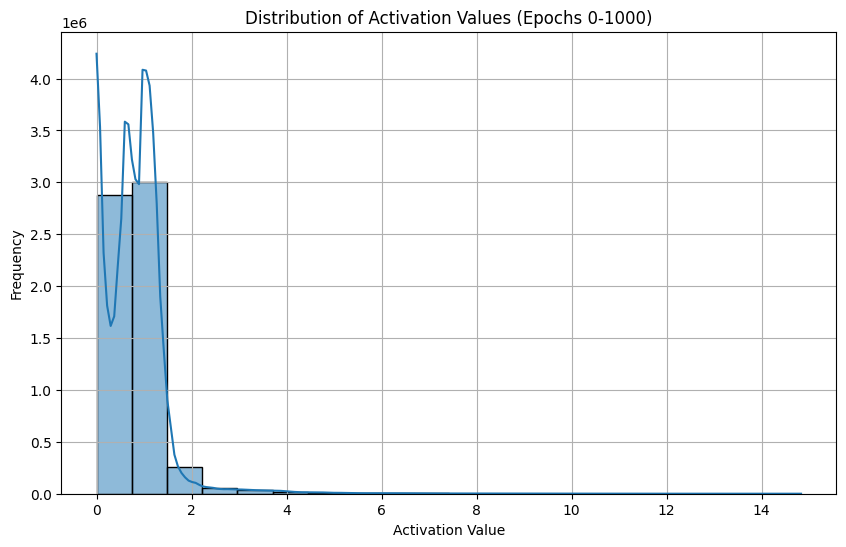

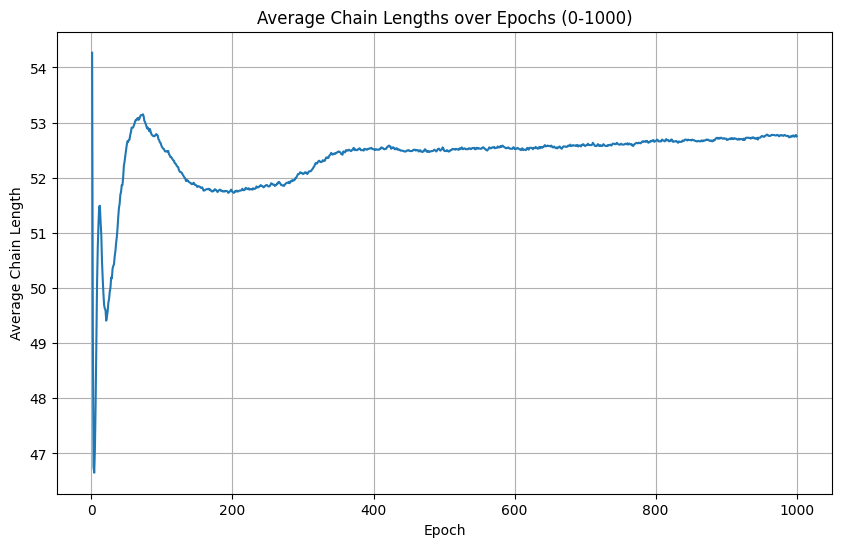

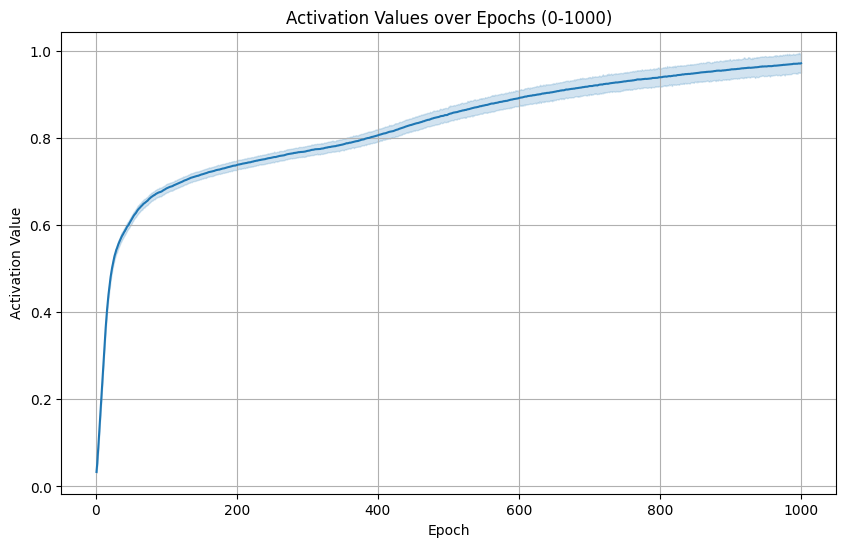

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the range of epochs for the analysis
min_epoch = 0
max_epoch = 1000

# Load the CSV file generated by the training process
csv_file = 'activation_chains.csv'
data = pd.read_csv(csv_file)

# Extract the epoch number from the Batch ID and filter for the range of interest
data['Epoch'] = data['Batch ID']
filtered_data = data[(data['Epoch'] >= min_epoch) & (data['Epoch'] <= max_epoch)]

# Ensure consistent chain length calculations
def calculate_chain_lengths(df):
    return df.groupby('Chain ID').size()

# General Analysis Metrics
def general_analysis_metrics(df):
    chain_lengths = calculate_chain_lengths(df)
    print(f"General Analysis Metrics for Epochs {min_epoch}-{max_epoch}:")
    print(f"Total number of activation chains: {df['Chain ID'].nunique()}")
    print(f"Total number of neurons activated: {len(df)}")
    print(f"Average chain length: {chain_lengths.mean():.2f}")
    print(f"Maximum chain length: {chain_lengths.max()}")
    print(f"Minimum chain length: {chain_lengths.min()}")
    print(f"Average activation value: {df['Activation Value'].mean():.4f}")
    print(f"Maximum activation value: {df['Activation Value'].max():.4f}")
    print(f"Minimum activation value: {df['Activation Value'].min():.4f}")
    print("\n")

# Call general analysis metrics on the filtered data
general_analysis_metrics(filtered_data)

# Visualizations

# 1. Distribution of Chain Lengths (Histogram)
plt.figure(figsize=(10, 6))
chain_lengths = calculate_chain_lengths(filtered_data)
sns.histplot(chain_lengths, kde=True, bins=20)
plt.title(f'Distribution of Chain Lengths (Epochs {min_epoch}-{max_epoch})')
plt.xlabel('Chain Length (Number of Neurons in the Chain)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Distribution of Activation Values
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['Activation Value'], kde=True, bins=20)
plt.title(f'Distribution of Activation Values (Epochs {min_epoch}-{max_epoch})')
plt.xlabel('Activation Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Average Chain Lengths over Epochs
plt.figure(figsize=(10, 6))
chain_lengths_over_epochs = filtered_data.groupby(['Epoch', 'Chain ID']).size().reset_index(name='Chain Length')
average_chain_lengths = chain_lengths_over_epochs.groupby('Epoch')['Chain Length'].mean()
sns.lineplot(x=average_chain_lengths.index, y=average_chain_lengths.values)
plt.title(f'Average Chain Lengths over Epochs ({min_epoch}-{max_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Average Chain Length')
plt.grid(True)
plt.show()

# 4. Activation Values over Epochs
plt.figure(figsize=(10, 6))
sns.lineplot(x='Epoch', y='Activation Value', data=filtered_data)
plt.title(f'Activation Values over Epochs ({min_epoch}-{max_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Activation Value')
plt.grid(True)
plt.show()

# Interactive Filter Function
def filter_analysis(min_epoch, max_epoch):
    filtered_df = data[(data['Epoch'] >= min_epoch) & (data['Epoch'] <= max_epoch)]
    
    print(f"Analysis for Epoch Range: {min_epoch} to {max_epoch}")
    general_analysis_metrics(filtered_df)
    
    # Distribution of Chain Lengths
    plt.figure(figsize=(10, 6))
    chain_lengths = calculate_chain_lengths(filtered_df)
    sns.histplot(chain_lengths, kde=True, bins=20)
    plt.title(f'Distribution of Chain Lengths (Epochs {min_epoch}-{max_epoch})')
    plt.xlabel('Chain Length (Number of Neurons in the Chain)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Distribution of Activation Values
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_df['Activation Value'], kde=True, bins=20)
    plt.title(f'Distribution of Activation Values (Epochs {min_epoch}-{max_epoch})')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # Average Chain Lengths over Epochs
    plt.figure(figsize=(10, 6))
    chain_lengths_over_epochs = filtered_df.groupby(['Epoch', 'Chain ID']).size().reset_index(name='Chain Length')
    average_chain_lengths = chain_lengths_over_epochs.groupby('Epoch')['Chain Length'].mean()
    sns.lineplot(x=average_chain_lengths.index, y=average_chain_lengths.values)
    plt.title(f'Average Chain Lengths over Epochs ({min_epoch}-{max_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Average Chain Length')
    plt.grid(True)
    plt.show()

    # Activation Values over Epochs
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Epoch', y='Activation Value', data=filtered_df)
    plt.title(f'Activation Values over Epochs ({min_epoch}-{max_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Activation Value')
    plt.grid(True)
    plt.show()

# Example usage of the filter_analysis function
filter_analysis(min_epoch, max_epoch)


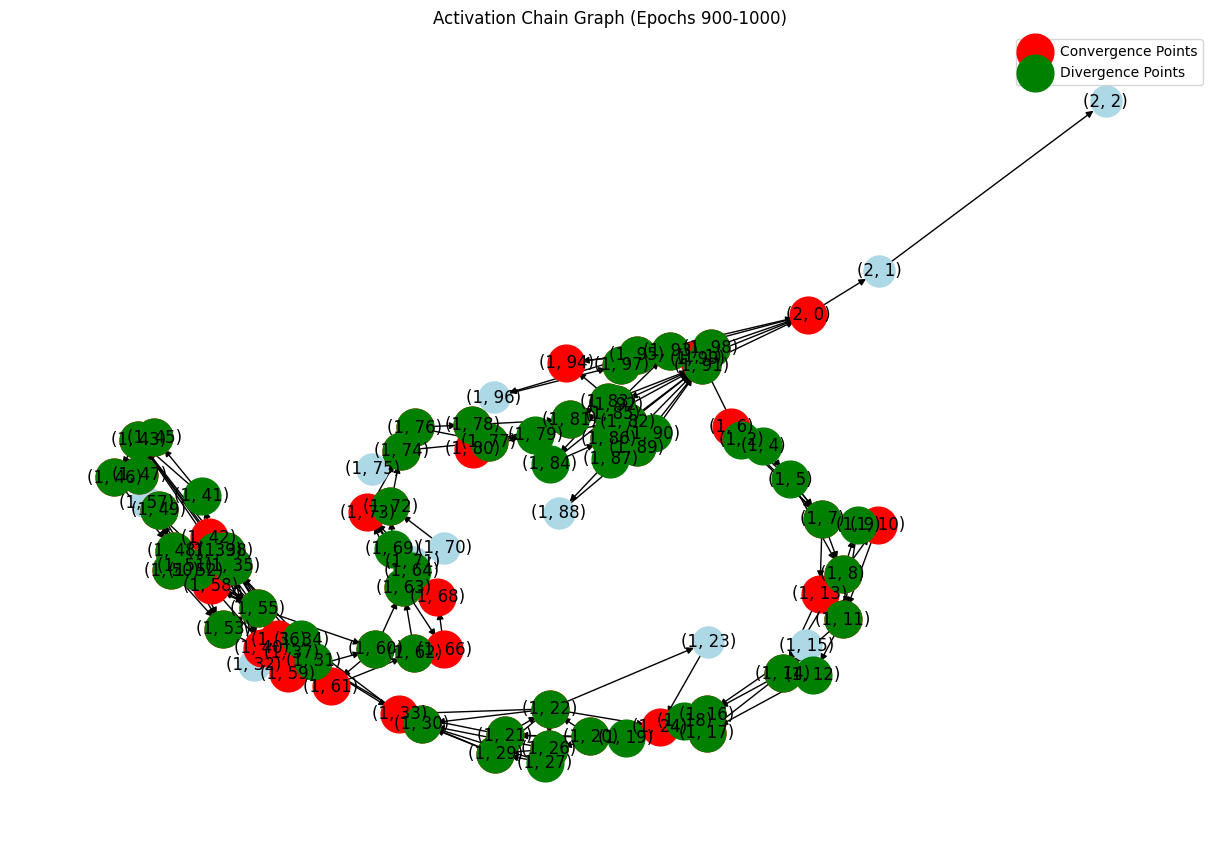

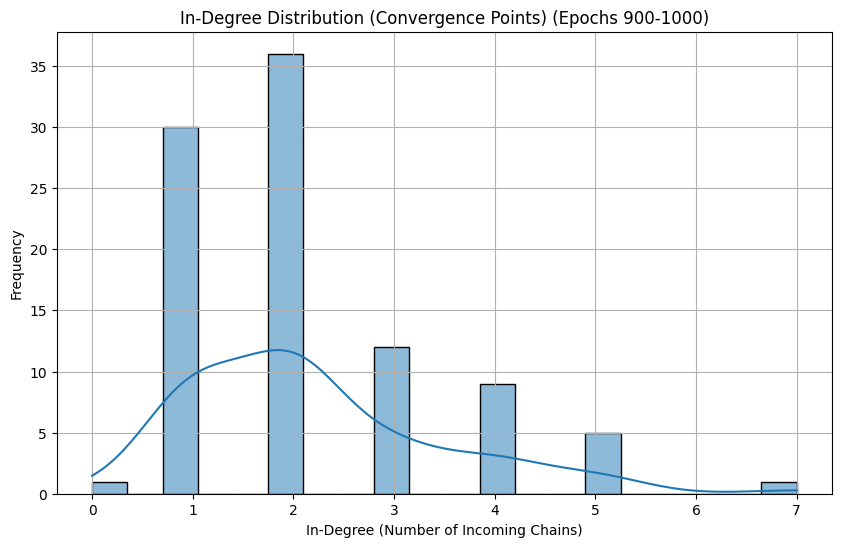

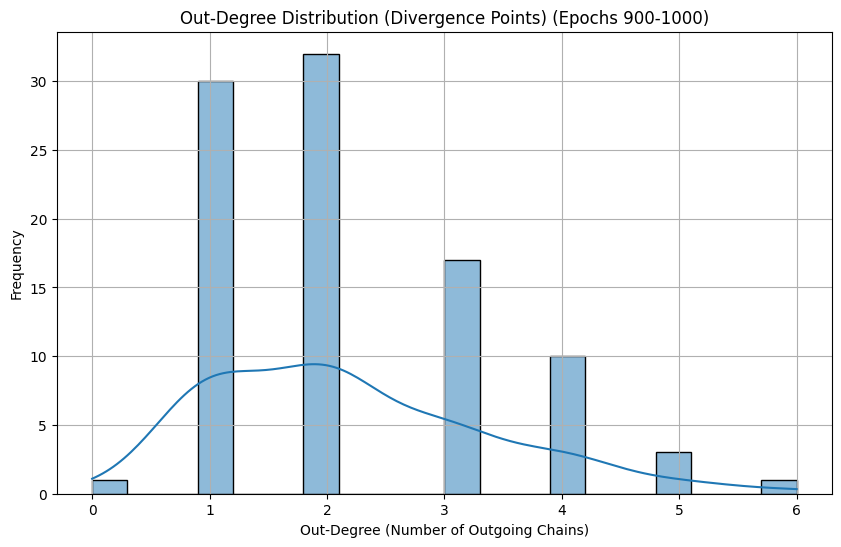

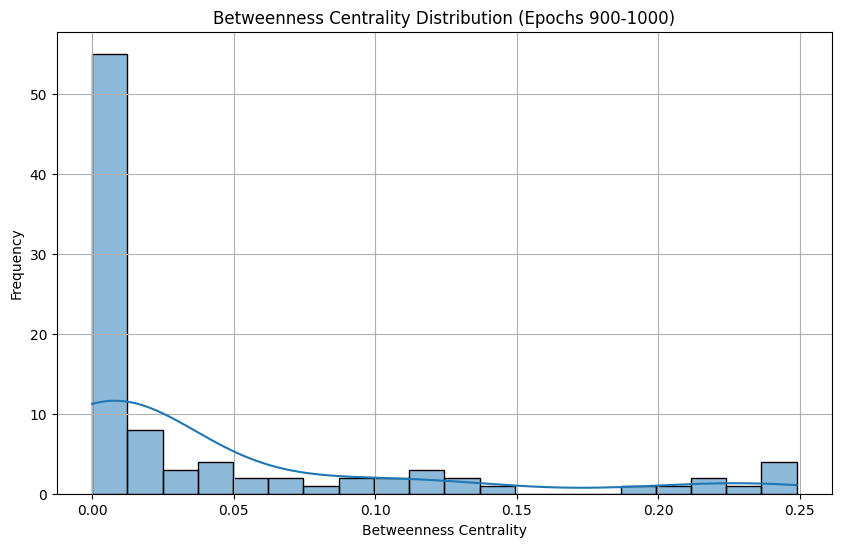

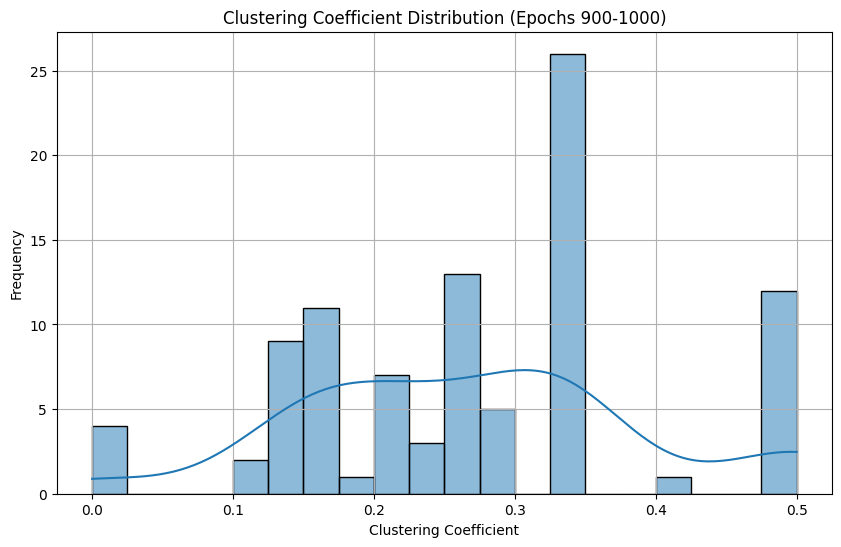

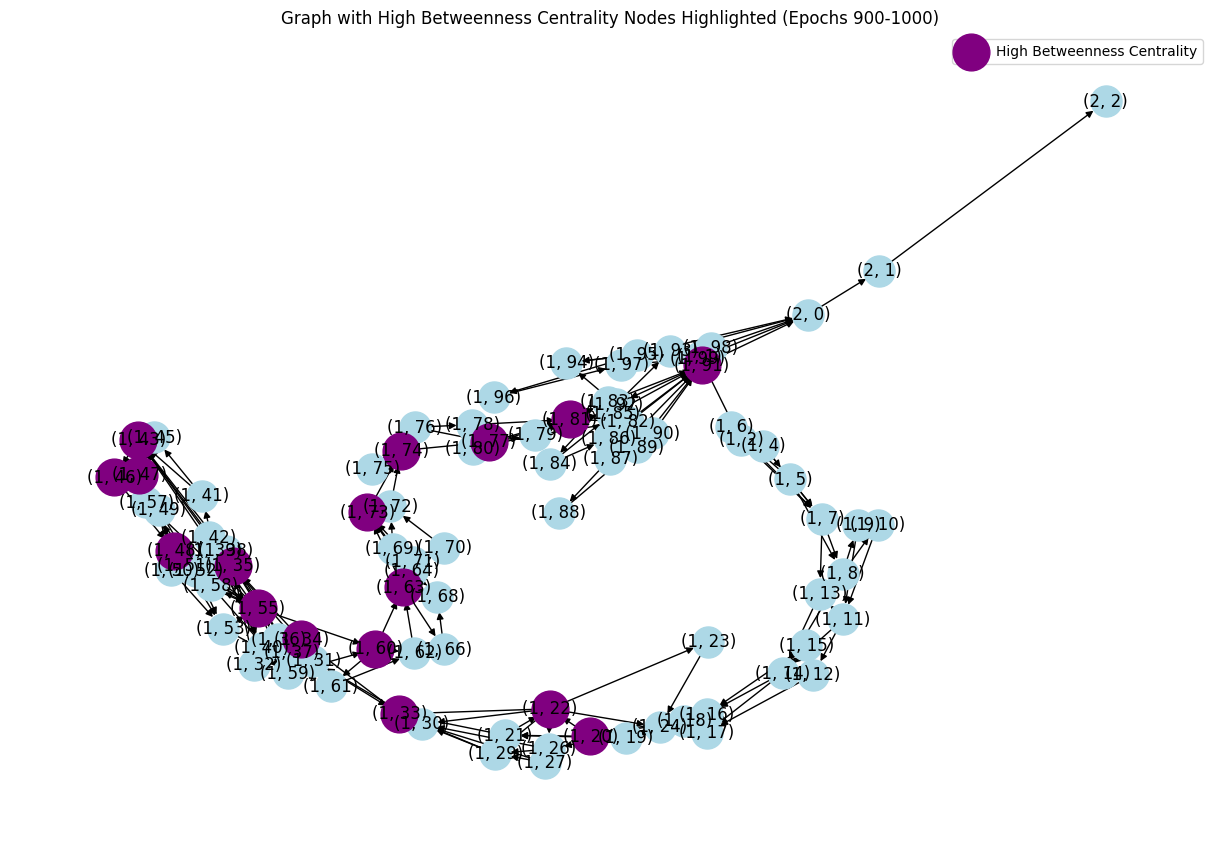

Summary of Overlap Analysis (Epochs 900-1000):
Number of Convergence Points: 63
Number of Divergence Points: 63
Nodes with High Betweenness Centrality: 17
Average Clustering Coefficient: 0.2712


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

# Set the range of epochs for the analysis
min_epoch = 900
max_epoch = 1000

# Load the CSV file generated by the training process
csv_file = 'activation_chains.csv'
data = pd.read_csv(csv_file)

# Extract the epoch number from the Batch ID and filter for the range of interest
data['Epoch'] = data['Batch ID']
filtered_data = data[(data['Epoch'] >= min_epoch) & (data['Epoch'] <= max_epoch)]

# Create a directed graph
G = nx.DiGraph()

# Build the graph from the filtered data
for _, row in filtered_data.iterrows():
    current_node = (row['Layer ID'], row['Neuron ID'])
    prev_neuron = row['Previous Neuron (Layer ID, Neuron ID)']
    
    # Ensure we only attempt to parse valid previous neuron references
    if pd.notnull(prev_neuron) and prev_neuron != 'None':
        prev_node_str = prev_neuron[1:-1]  # Remove parentheses
        prev_layer, prev_neuron = map(int, prev_node_str.split(', '))
        prev_node = (prev_layer, prev_neuron)
        G.add_edge(prev_node, current_node)

# Analyze overlap, convergence, and divergence

# 1. Node Degree Analysis
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

# Convergence Points (High In-Degree)
convergence_points = {node: deg for node, deg in in_degrees.items() if deg > 1}

# Divergence Points (High Out-Degree)
divergence_points = {node: deg for node, deg in out_degrees.items() if deg > 1}

# 2. Centrality Measures
# Betweenness Centrality: Nodes that often sit on the shortest paths between other nodes
centrality = nx.betweenness_centrality(G)
high_centrality_nodes = {node: centrality[node] for node in centrality if centrality[node] > 0.1}  # Example threshold

# Clustering Coefficient: Indicates how tightly knit a node's neighborhood is
clustering_coefficients = nx.clustering(G)

# Visualization

# 1. Basic Graph Visualization with Convergence and Divergence Highlighted
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Positioning of nodes for visual clarity
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', arrows=True)
nx.draw_networkx_nodes(G, pos, nodelist=convergence_points.keys(), node_color='red', node_size=700, label='Convergence Points')
nx.draw_networkx_nodes(G, pos, nodelist=divergence_points.keys(), node_color='green', node_size=700, label='Divergence Points')
plt.title(f"Activation Chain Graph (Epochs {min_epoch}-{max_epoch})")
plt.legend()
plt.show()

# 2. In-Degree Distribution (Convergence Points)
plt.figure(figsize=(10, 6))
in_degree_values = list(in_degrees.values())
sns.histplot(in_degree_values, kde=True, bins=20)
plt.title(f'In-Degree Distribution (Convergence Points) (Epochs {min_epoch}-{max_epoch})')
plt.xlabel('In-Degree (Number of Incoming Chains)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. Out-Degree Distribution (Divergence Points)
plt.figure(figsize=(10, 6))
out_degree_values = list(out_degrees.values())
sns.histplot(out_degree_values, kde=True, bins=20)
plt.title(f'Out-Degree Distribution (Divergence Points) (Epochs {min_epoch}-{max_epoch})')
plt.xlabel('Out-Degree (Number of Outgoing Chains)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 4. Betweenness Centrality Distribution
plt.figure(figsize=(10, 6))
centrality_values = list(centrality.values())
sns.histplot(centrality_values, kde=True, bins=20)
plt.title(f'Betweenness Centrality Distribution (Epochs {min_epoch}-{max_epoch})')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 5. Clustering Coefficient Distribution
plt.figure(figsize=(10, 6))
clustering_values = list(clustering_coefficients.values())
sns.histplot(clustering_values, kde=True, bins=20)
plt.title(f'Clustering Coefficient Distribution (Epochs {min_epoch}-{max_epoch})')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 6. Highlighting High Betweenness Centrality Nodes
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', arrows=True)
nx.draw_networkx_nodes(G, pos, nodelist=high_centrality_nodes.keys(), node_color='purple', node_size=700, label='High Betweenness Centrality')
plt.title(f"Graph with High Betweenness Centrality Nodes Highlighted (Epochs {min_epoch}-{max_epoch})")
plt.legend()
plt.show()

# Summary of Findings
print(f"Summary of Overlap Analysis (Epochs {min_epoch}-{max_epoch}):")
print(f"Number of Convergence Points: {len(convergence_points)}")
print(f"Number of Divergence Points: {len(divergence_points)}")
print(f"Nodes with High Betweenness Centrality: {len(high_centrality_nodes)}")
print(f"Average Clustering Coefficient: {sum(clustering_values)/len(clustering_values):.4f}")
